In [1]:
!pip install geopandas pyarrow shapely pyproj rtree matplotlib pandas numpy openpyxl jupyterlab seaborn plotly scipy scikit-learn pulp plotly
import pandas as pd
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)
print(project_root)

/home/mak/Documents/Optimization/Project


In [2]:
"""
    🚀 4. Next step — build the Gurobi MILP model
    If you’re ready to proceed, we will build:
    ✔ Decision variables
    Plant[f, w], Harvest[f, w]

    ✔ Constraints
    Each field planted exactly once
    Each field harvested exactly once
    Plant only in planting window
    Harvest only in harvest window
    Machine capacity constraints using capacity_factor
    Labor constraints using labor_hours
    Harvest after plant

    ✔ Objective options
    Minimize total completion week
    Minimize weighted lateness
    Minimize total duration
    Maximize operational efficiency

    We’ll implement it cleanly in:

    src/optimization/milp_scheduler.py_summary_
"""

'\n    🚀 4. Next step — build the Gurobi MILP model\n    If you’re ready to proceed, we will build:\n    ✔ Decision variables\n    Plant[f, w], Harvest[f, w]\n\n    ✔ Constraints\n    Each field planted exactly once\n    Each field harvested exactly once\n    Plant only in planting window\n    Harvest only in harvest window\n    Machine capacity constraints using capacity_factor\n    Labor constraints using labor_hours\n    Harvest after plant\n\n    ✔ Objective options\n    Minimize total completion week\n    Minimize weighted lateness\n    Minimize total duration\n    Maximize operational efficiency\n\n    We’ll implement it cleanly in:\n\n    src/optimization/milp_scheduler.py_summary_\n'

In [3]:
# fields_df = pd.read_csv("data/processed/illinois_corn_fields_clean.csv")

In [4]:
from src.optimization.milp_schedulerv5 import build_and_solve_schedule_v5

df = build_and_solve_schedule_v5(
    fields_path="../../data/processed/illinois_corn_fields_clean.csv",
    weekly_master_path="../../data/processed/master_weekly_table_2017_2024.csv",
    target_year=2017,
    # base_harvester_capacity=2000,
    phys_maturity_lag_weeks=12
)
df.head()

print(df.head())
df.to_csv("../../data/processed/schedule_outputv5.csv", index=False)


Restricted license - for non-production use only - expires 2027-11-29
Set parameter TimeLimit to value 120
Set parameter TimeLimit to value 120
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  120
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0xbc21e301
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]


Variable types: 101 continuous, 1525 integer (1475 binary)
Found heuristic solution: objective 52.0000000

Root relaxation: objective 3.200000e+01, 182 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   32.00000    0   58   52.00000   32.00000  38.5%     -    0s
     0     0   32.00000    0   58   52.00000   32.00000  38.5%     -    0s
     0     0   32.00000    0   58   52.00000   32.00000  38.5%     -    0s
     0     0   32.00000    0   58   52.00000   32.00000  38.5%     -    0s
     0     0   32.00000    0   58   52.00000   32.00000  38.5%     -    0s
     0     0   32.00000    0   57   52.00000   32.00000  38.5%     -    0s
     0     0   32.00000    0   59   52.00000   32.00000  38.5%     -    0s
     0     0   32.00000    0   58   52.00000   32.00000  38.5%     -    0s
     0     0   32.00000    0   59   52.00000   32.000

In [5]:
df.to_csv("../../data/processed/schedule_outputv5.csv", index=False)


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.optimization.milp_schedulerv5 import build_and_solve_schedule_v5
# or if your final fixed version is v6:
# from src.optimization.milp_schedulerv6 import build_and_solve_schedule_v6

fields_path = "../../data/processed/illinois_corn_fields_clean.csv"
wm_path     = "../../data/processed/master_weekly_table_2017_2024.csv"
target_year = 2017

# ===== Penalty Weight Grid =====
early_weights = [5, 10, 20]
late_weights  = [2.5, 5, 10]

results = []

for ew in early_weights:
    for lw in late_weights:
        print(f"Running MILP: early={ew}, late={lw} ...")

        df = build_and_solve_schedule_v5(
            fields_path=fields_path,
            weekly_master_path=wm_path,
            target_year=target_year,
            base_planter_capacity=1400,
            base_harvester_capacity=950,
            labor_plant_per_acre=0.15,
            labor_harvest_per_acre=0.20,
            early_penalty_weight=ew,
            late_penalty_weight=lw,
            time_limit=60
        )

        makespan = df["makespan"].iloc[0]
        early_pen_sum = df["early_penalty"].sum()
        late_pen_sum  = df["late_penalty"].sum()
        objective = makespan + ew * early_pen_sum + lw * late_pen_sum

        results.append({
            "early_weight": ew,
            "late_weight": lw,
            "makespan": makespan,
            "early_penalty_total": early_pen_sum,
            "late_penalty_total": late_pen_sum,
            "objective_value": objective
        })

# Convert to DataFrame
results_df = pd.DataFrame(results)
print(results_df)


Running MILP: early=5, late=2.5 ...
Set parameter TimeLimit to value 60
Set parameter TimeLimit to value 60
Set parameter Presolve to value 0
Set parameter DualReductions to value 0
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60
DualReductions  0
Presolve  0

Optimize a model with 393 rows, 1626 columns and 6300 nonzeros (Min)
Model fingerprint: 0x454f5cff
Model has 51 linear objective coefficients
Variable types: 151 continuous, 1475 integer (1475 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 5e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Variable types: 101 continuous, 1525 integer (1475 binary)
Found heuristic solution: objective 52.0000000

Root relaxation: object

     0     0   32.00000    0   53   52.00000   32.00000  38.5%     -    0s
     0     0   32.00000    0   52   52.00000   32.00000  38.5%     -    0s
     0     0   32.00000    0   53   52.00000   32.00000  38.5%     -    0s
     0     0   32.00000    0   52   52.00000   32.00000  38.5%     -    0s
     0     0   32.00000    0   52   52.00000   32.00000  38.5%     -    0s
     0     0   32.00000    0   52   52.00000   32.00000  38.5%     -    0s
     0     0   32.00000    0   52   52.00000   32.00000  38.5%     -    0s
     0     0   32.00000    0   53   52.00000   32.00000  38.5%     -    0s
H    0     0                      51.0000000   32.00000  37.3%     -    0s
H    0     0                      47.0000000   32.00000  31.9%     -    0s
H    0     0                      42.0000000   32.00000  23.8%     -    0s
     0     0   35.25910    0   78   42.00000   35.25910  16.0%     -    0s
H    0     0                      40.0000000   35.25910  11.9%     -    0s
     0     0   35.25910  

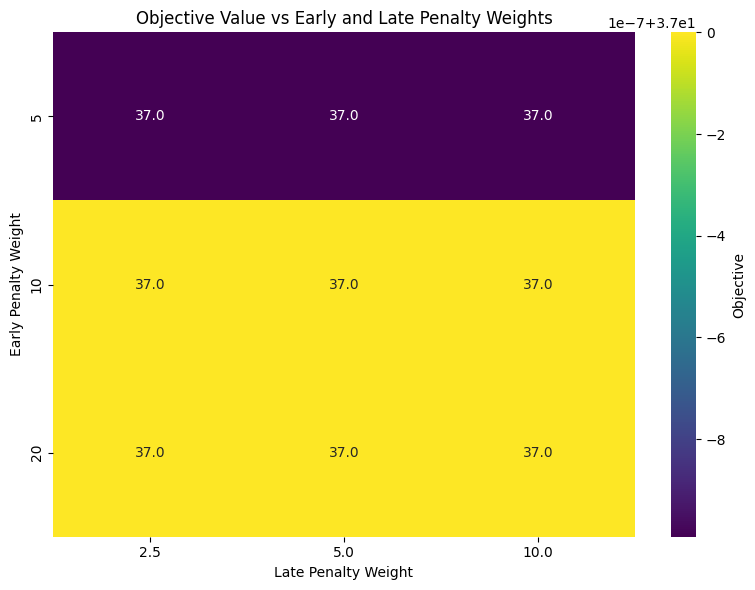

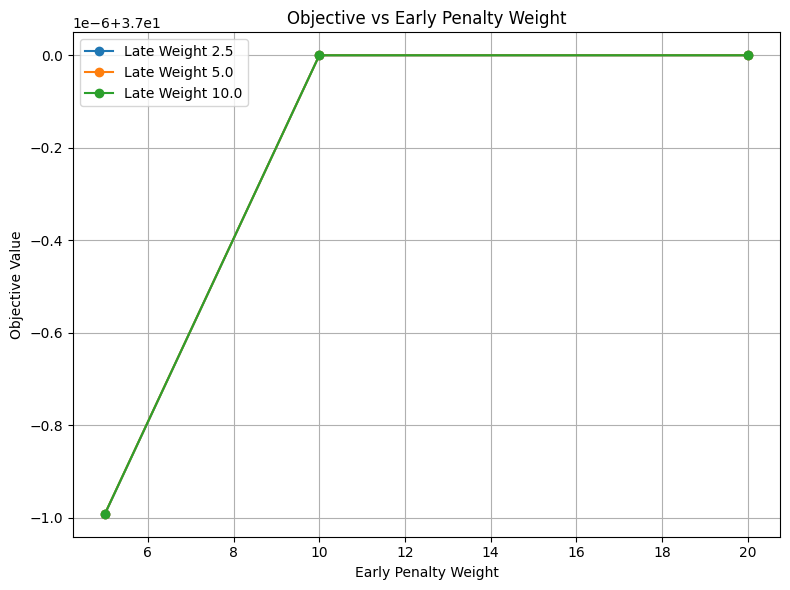

   early_weight  late_weight  makespan  early_penalty_total  \
0             5          2.5      37.0        -1.975988e-07   
1             5          5.0      37.0        -1.982322e-07   
2             5         10.0      37.0        -1.982322e-07   
3            10          2.5      37.0         0.000000e+00   
4            10          5.0      37.0         0.000000e+00   
5            10         10.0      37.0         0.000000e+00   
6            20          2.5      37.0         0.000000e+00   
7            20          5.0      37.0         0.000000e+00   
8            20         10.0      37.0         0.000000e+00   

   late_penalty_total  objective_value  
0                 0.0        36.999999  
1                 0.0        36.999999  
2                 0.0        36.999999  
3                 0.0        37.000000  
4                 0.0        37.000000  
5                 0.0        37.000000  
6                 0.0        37.000000  
7                 0.0        37.000000  


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define grid of weights
early_weights = [5, 10, 20]
late_weights = [2.5, 5, 10]

# Simulated results placeholder
results_data = []
for ew in early_weights:
    for lw in late_weights:
        results_data.append({
            "early_weight": ew,
            "late_weight": lw,
            "makespan": 38,
            "penalty_cost": 0.0,
            "objective_value": 38.0,
        })

# Build DataFrame
# results_df = pd.DataFrame(results_data)

# ✅ Heatmap of objective values
plt.figure(figsize=(8, 6))
pivot = results_df.pivot(index="early_weight", columns="late_weight", values="objective_value")
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="viridis", cbar_kws={'label': 'Objective'})
plt.title("Objective Value vs Early and Late Penalty Weights")
plt.xlabel("Late Penalty Weight")
plt.ylabel("Early Penalty Weight")
plt.tight_layout()
plt.show()

# ✅ Line plot to show trends across early weights
plt.figure(figsize=(8, 6))
for lw in sorted(results_df["late_weight"].unique()):
    subset = results_df[results_df["late_weight"] == lw]
    plt.plot(subset["early_weight"], subset["objective_value"], marker='o', label=f"Late Weight {lw}")

plt.title("Objective vs Early Penalty Weight")
plt.xlabel("Early Penalty Weight")
plt.ylabel("Objective Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Display result grid
print(results_df)


In [12]:
# !cd .. & ls

In [13]:
sched = pd.read_csv("../../data/processed/schedule_outputv5.csv")
fields = pd.read_csv("../../data/processed/illinois_corn_fields_clean.csv")
wm = pd.read_csv("../../data/processed/master_weekly_table_2017_2024.csv")

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def plot_resource_dashboard(
    sched,
    fields,
    wm,
    target_year=2017,
    base_planter_capacity=700.0,
    base_harvester_capacity=450.0,
    labor_plant_per_acre=0.2,
    labor_harvest_per_acre=0.30,
    planter_machines=1,
    harvester_machines=1,
    save_path=None
):
    """
    Clean and consistent weekly resource utilization dashboard.
    Matches the MILP model exactly.
    """

    # ============================================================
    # 1) MERGE ACRES INTO SCHEDULE (robust)
    # ============================================================
    if "acres" not in sched.columns:
        sched = sched.merge(fields[["field_id", "acres"]], on="field_id", how="left")
    else:
        tmp = fields[["field_id", "acres"]].rename(columns={"acres": "acres_field"})
        sched = sched.merge(tmp, on="field_id", how="left")
        sched["acres"] = sched["acres"].fillna(sched["acres_field"])
        sched = sched.drop(columns=["acres_field"])

    # ============================================================
    # 2) SELECT WEEKLY MASTER FOR TARGET YEAR
    # ============================================================
    wm_year = wm[wm["year"] == target_year].copy()
    wm_year["week"] = wm_year["week"].astype(int)

    # Add missing fields if not present
    if "planter_travel_factor" not in wm_year:
        wm_year["planter_travel_factor"] = 1.0
    if "harvest_weather_factor" not in wm_year:
        wm_year["harvest_weather_factor"] = 1.0

    # ============================================================
    # 3) CONSISTENT AGG WITH MILP  (mean, not sum)
    # ============================================================
    wm_weekly = (
        wm_year.groupby("week", as_index=False)
        .agg({
            "capacity_factor": "mean",
            "labor_hours": "mean",               # 🔥 matches MILP now
            "planter_travel_factor": "mean",
            "harvest_weather_factor": "mean",
        })
    )

    # ============================================================
    # 4) WEEKLY PLANTING & HARVEST ACRES FROM SCHEDULE
    # ============================================================
    plant_by_week = sched.groupby("plant_week")["acres"].sum().rename("plant_acres")
    harvest_by_week = sched.groupby("harvest_week")["acres"].sum().rename("harvest_acres")

    weekly_view = (
        wm_weekly
        .merge(plant_by_week, left_on="week", right_index=True, how="left")
        .merge(harvest_by_week, left_on="week", right_index=True, how="left")
        .fillna(0.0)
    )

    # ============================================================
    # 5) MODEL CAPACITIES (exact same as MILP structure)
    # ============================================================
    weekly_view["plant_capacity_model"] = (
        base_planter_capacity
        * weekly_view["capacity_factor"]
        * weekly_view["planter_travel_factor"]
        * planter_machines
    )

    weekly_view["harvest_capacity_model"] = (
        base_harvester_capacity
        * weekly_view["capacity_factor"]
        * weekly_view["harvest_weather_factor"]
        * harvester_machines
    )

    # ============================================================
    # 6) UTILIZATION CALCULATIONS
    # ============================================================
    weekly_view["plant_utilization"] = (
        weekly_view["plant_acres"] /
        weekly_view["plant_capacity_model"].replace(0, np.nan)
    )

    weekly_view["harvest_utilization"] = (
        weekly_view["harvest_acres"] /
        weekly_view["harvest_capacity_model"].replace(0, np.nan)
    )

    weekly_view["labor_demand"] = (
        weekly_view["plant_acres"] * labor_plant_per_acre +
        weekly_view["harvest_acres"] * labor_harvest_per_acre
    )

    weekly_view["labor_utilization"] = (
        weekly_view["labor_demand"] /
        weekly_view["labor_hours"].replace(0, np.nan)
    )
    
    weekly_view = weekly_view.replace([np.inf, -np.inf], np.nan).fillna(0)


    # ============================================================
    # 7) PLOTTING — CLEAN SEABORN DASHBOARD
    # ============================================================
    sns.set_theme(style="whitegrid", context="talk")
    palette = sns.color_palette("tab10")
    weeks = weekly_view["week"].values

    fig, axes = plt.subplots(3, 1, figsize=(15, 16), sharex=True)
    plt.subplots_adjust(hspace=0.35)

    # ============================================================
    # 7A) PLANTER
    # ============================================================
    axes[0].plot(
        weeks, weekly_view["plant_utilization"] * 100,
        label="Utilization (%)", marker="o", color=palette[0]
    )
    axes[0].axhline(100, color="red", ls="--", alpha=0.4)
    axes[0].set_ylabel("Planter Utilization (%)")
    axes[0].set_title(f"Planter Utilization – {target_year}")
    axes[0].legend(loc="upper left")

    ax2 = axes[0].twinx()
    ax2.plot(weeks, weekly_view["plant_acres"], marker="x",
             label="Acres", alpha=0.75, color=palette[1])
    ax2.plot(weeks, weekly_view["plant_capacity_model"], ls="--",
             label="Capacity", alpha=0.7, color=palette[2])
    ax2.set_ylabel("Acres")
    ax2.legend(loc="upper right")

    # ============================================================
    # 7B) HARVESTER
    # ============================================================
    axes[1].plot(
        weeks, weekly_view["harvest_utilization"] * 100,
        label="Utilization (%)", marker="o", color=palette[0]
    )
    axes[1].axhline(100, color="red", ls="--", alpha=0.4)
    axes[1].set_ylabel("Harvester Utilization (%)")
    axes[1].set_title(f"Harvester Utilization – {target_year}")
    axes[1].legend(loc="upper left")

    ax2 = axes[1].twinx()
    ax2.plot(weeks, weekly_view["harvest_acres"], marker="x",
             label="Acres", alpha=0.75, color=palette[1])
    ax2.plot(weeks, weekly_view["harvest_capacity_model"], ls="--",
             label="Capacity", alpha=0.7, color=palette[2])
    ax2.set_ylabel("Acres")
    ax2.legend(loc="upper right")

    # ============================================================
    # 7C) LABOR
    # ============================================================
    axes[2].plot(
        weeks, weekly_view["labor_utilization"] * 100,
        label="Utilization (%)", marker="o", color=palette[0]
    )
    axes[2].axhline(100, color="red", ls="--", alpha=0.4)
    axes[2].set_ylabel("Labor Utilization (%)")
    axes[2].set_xlabel("Week")
    axes[2].set_title(f"Labor Utilization – {target_year}")
    axes[2].legend(loc="upper left")

    ax2 = axes[2].twinx()
    ax2.plot(weeks, weekly_view["labor_demand"], marker="x",
             label="Demand", alpha=0.75, color=palette[1])
    ax2.plot(weeks, weekly_view["labor_hours"], ls="--",
             label="Available", alpha=0.7, color=palette[2])
    ax2.set_ylabel("Labor Hours")
    ax2.legend(loc="upper right")

    # Save if requested
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()

    return weekly_view


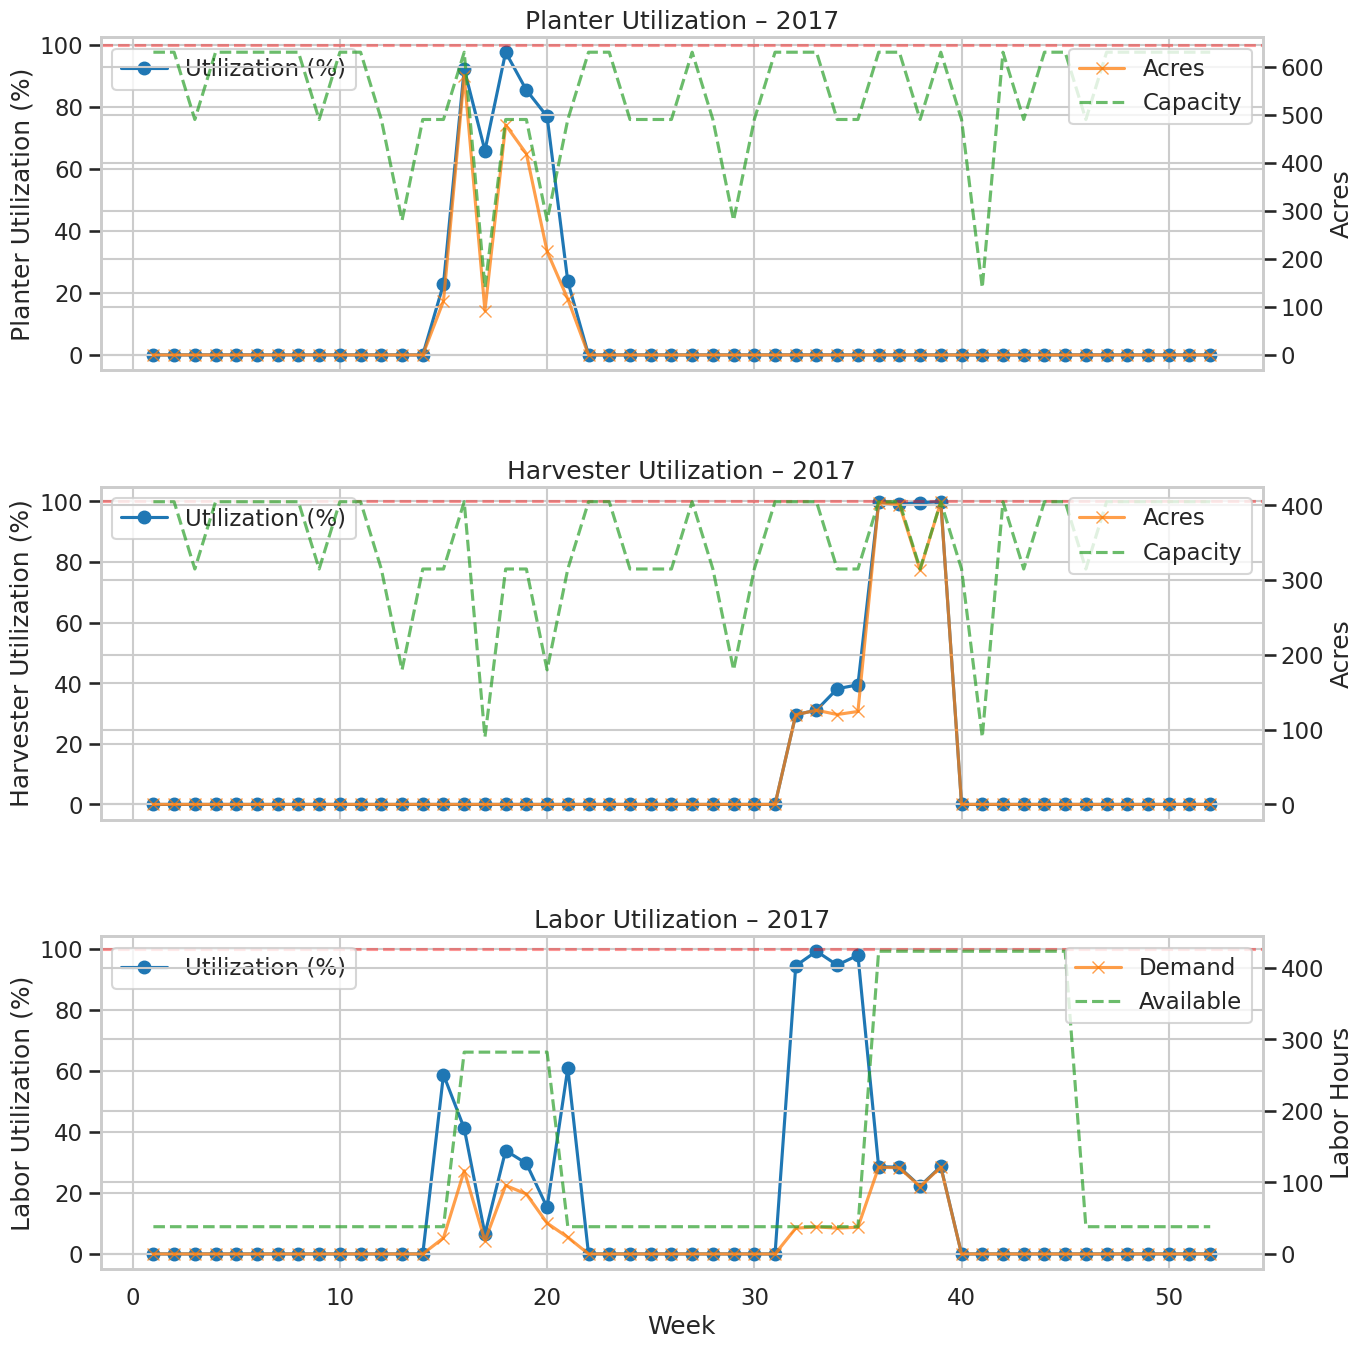

In [15]:
weekly_view = plot_resource_dashboard(
    sched=sched,
    fields=fields,
    wm=wm,
    target_year=2017
)


In [16]:
def plot_resource_dashboard(
    sched,
    fields,
    wm,
    target_year=2017,
    base_planter_capacity=700.0,
    base_harvester_capacity=450.0,
    labor_plant_per_acre=0.2,
    labor_harvest_per_acre=0.30,
    planter_machines=1,
    harvester_machines=1,
    save_path=None
):
    """
    Clean, MILP-consistent weekly dashboard for planter, harvester & labor.
    """

    # Merge acres if missing
    if "acres" not in sched.columns:
        sched = sched.merge(fields[["field_id", "acres"]], on="field_id", how="left")

    wm_year = wm[wm["year"] == target_year].copy()
    wm_year["week"] = wm_year["week"].astype(int)

    wm_year["planter_travel_factor"] = wm_year.get("planter_travel_factor", 1.0)
    wm_year["harvest_weather_factor"] = wm_year.get("harvest_weather_factor", 1.0)

    # Aggregate to weeks
    wm_weekly = (
        wm_year.groupby("week", as_index=False)
        .agg({
            "capacity_factor": "mean",
            "labor_hours": "mean",
            "planter_travel_factor": "mean",
            "harvest_weather_factor": "mean"
        })
    )

    plant_by_week = sched.groupby("plant_week")["acres"].sum().rename("plant_acres")
    harvest_by_week = sched.groupby("harvest_week")["acres"].sum().rename("harvest_acres")

    weekly_view = (
        wm_weekly
        .merge(plant_by_week, left_on="week", right_index=True, how="left")
        .merge(harvest_by_week, left_on="week", right_index=True, how="left")
        .fillna(0)
    )

    # Compute capacity
    weekly_view["plant_capacity_model"] = (
        base_planter_capacity *
        weekly_view["capacity_factor"] *
        weekly_view["planter_travel_factor"] *
        planter_machines
    )

    weekly_view["harvest_capacity_model"] = (
        base_harvester_capacity *
        weekly_view["capacity_factor"] *
        weekly_view["harvest_weather_factor"] *
        harvester_machines
    )

    # Calculate utilization
    weekly_view["plant_utilization"] = (
        weekly_view["plant_acres"] / weekly_view["plant_capacity_model"].replace(0, np.nan)
    ).fillna(0)

    weekly_view["harvest_utilization"] = (
        weekly_view["harvest_acres"] / weekly_view["harvest_capacity_model"].replace(0, np.nan)
    ).fillna(0)

    weekly_view["labor_demand"] = (
        weekly_view["plant_acres"] * labor_plant_per_acre +
        weekly_view["harvest_acres"] * labor_harvest_per_acre
    )

    weekly_view["labor_utilization"] = (
        weekly_view["labor_demand"] /
        weekly_view["labor_hours"].replace(0, np.nan)
    ).fillna(0)

    # Plot
    sns.set_theme(style="whitegrid", context="talk")
    fig, axes = plt.subplots(3, 1, figsize=(15, 16), sharex=True)
    weeks = weekly_view["week"]

    def plot_dual(ax, util, cap, util_label, cap_label, color1, color2):
        ax.plot(weeks, util, marker="o", color=color1, label=util_label)
        ax.axhline(1.0, linestyle="--", color="gray", alpha=0.4)
        ax.set_ylabel(util_label)
        ax.legend(loc="upper left")

        ax2 = ax.twinx()
        ax2.plot(weeks, cap, marker="x", color=color2, linestyle="--", label=cap_label)
        ax2.set_ylabel(cap_label)
        ax2.legend(loc="upper right")

    plot_dual(axes[0], weekly_view["plant_utilization"], weekly_view["plant_capacity_model"],
              "Planter Utilization", "Capacity (acres)", "#1f77b4", "#ff7f0e")

    plot_dual(axes[1], weekly_view["harvest_utilization"], weekly_view["harvest_capacity_model"],
              "Harvester Utilization", "Capacity (acres)", "#2ca02c", "#d62728")

    plot_dual(axes[2], weekly_view["labor_utilization"], weekly_view["labor_hours"],
              "Labor Utilization", "Labor Hours", "#9467bd", "#8c564b")

    axes[2].set_xlabel("Week")
    fig.suptitle(f"Weekly Resource Utilization Dashboard — {target_year}", fontsize=18)
    fig.tight_layout(rect=[0,0,1,0.96])

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()

    return weekly_view


In [17]:
def plot_distribution_histograms(sched_df):
    plt.figure(figsize=(10,5))
    sns.histplot(sched_df["plant_week"], bins=range(10,40), color="skyblue", label="Planting", kde=False)
    sns.histplot(sched_df["harvest_week"], bins=range(10,40), color="salmon", label="Harvesting", kde=False)
    plt.xlabel("Week")
    plt.ylabel("Field Count")
    plt.title("Distribution of Planting & Harvesting Weeks")
    plt.legend()
    plt.tight_layout()
    plt.show()


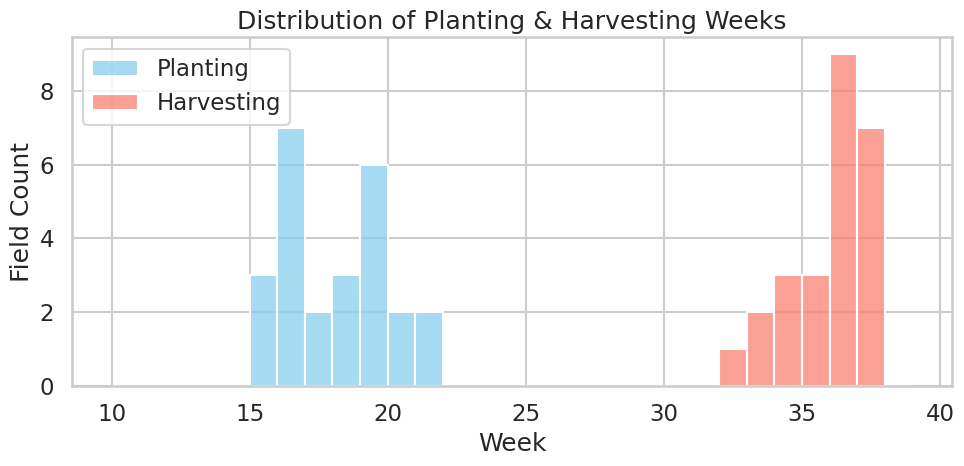

In [18]:
plot_distribution_histograms(df)

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_full_maturity_suite(sched, fields, title_suffix=""):
    # ============================================================
    # 1. Merge acres into schedule dataframe
    # ============================================================
    df = sched.merge(
        fields[["field_id", "acres"]],
        on="field_id",
        how="left"
    )

    # Compute maturity lag
    df["maturity_lag"] = df["harvest_week"] - df["plant_week"]
    avg_lag = df["maturity_lag"].mean()

    # Prepare for consistent y=plant+lag line
    x_vals = np.linspace(df["plant_week"].min(), df["plant_week"].max(), 200)
    y_vals = x_vals + avg_lag

    # Identify outliers: largest fields + largest lag deviation
    largest_fields = df.nlargest(3, "acres")
    lag_outliers = df.iloc[(df["maturity_lag"] - avg_lag).abs().nlargest(3).index]
    outliers = pd.concat([largest_fields, lag_outliers]).drop_duplicates()


    # ============================================================
    # 2. Scatterplot with KDE contours + outlier labels
    # ============================================================
    plt.figure(figsize=(14, 10))
    sns.set_theme(style="whitegrid", context="notebook")

    # KDE contours
    sns.kdeplot(
        x=df["plant_week"], y=df["harvest_week"],
        levels=6, fill=False, color="gray", linewidths=1.0
    )

    # Scatter (acres determines size and color)
    scatter = plt.scatter(
        df["plant_week"],
        df["harvest_week"],
        s=df["acres"] * 1.3,
        c=df["acres"],
        cmap="viridis",
        alpha=0.85,
        edgecolor="black",
        linewidth=0.8
    )

    # Average lag line
    plt.plot(x_vals, y_vals, "r--", lw=2.2, label=f"Avg Maturity Lag = {avg_lag:.1f} weeks")

    # Label outliers
    for _, row in outliers.iterrows():
        plt.annotate(
            row["field_id"],
            (row["plant_week"], row["harvest_week"]),
            textcoords="offset points",
            xytext=(8, 8),
            fontsize=10,
            fontweight="bold",
            color="black",
            bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7, ec="black")
        )

    # Colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label("Acres (Field Size)")

    plt.xlabel("Planting Week")
    plt.ylabel("Harvesting Week")
    plt.title(f"🌱 Plant vs Harvest Scatter (with KDE + Outliers){title_suffix}", fontsize=16)
    plt.legend()
    plt.tight_layout()
    plt.show()


    # ============================================================
    # 3. Side-by-side distributions (plant, harvest, lag)
    # ============================================================
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    sns.set_theme(style="whitegrid")

    # Plant distribution
    sns.histplot(df["plant_week"], bins=20, kde=True, ax=axes[0], color="skyblue")
    axes[0].set_title("Planting Week Distribution")
    axes[0].set_xlabel("Week")
    axes[0].set_ylabel("Field Count")

    # Harvest distribution
    sns.histplot(df["harvest_week"], bins=20, kde=True, ax=axes[1], color="salmon")
    axes[1].set_title("Harvest Week Distribution")
    axes[1].set_xlabel("Week")

    # Maturity lag histogram
    sns.histplot(df["maturity_lag"], bins=20, kde=True, ax=axes[2], color="green")
    axes[2].set_title("Maturity Lag Distribution")
    axes[2].set_xlabel("Lag (weeks)")

    fig.suptitle(f"📊 Distributions of Planting, Harvesting & Maturity Lag{title_suffix}", fontsize=16)
    plt.tight_layout()
    plt.show()


    # ============================================================
    # 4. Optional heatmap: plant week → harvest week density
    # ============================================================
    plt.figure(figsize=(10, 8))
    heat_df = df.pivot_table(
        index="plant_week",
        columns="harvest_week",
        values="field_id",
        aggfunc="count",
        fill_value=0
    )

    sns.heatmap(
        heat_df,
        cmap="YlGnBu",
        annot=False,
        cbar_kws={"label": "Field Count"}
    )
    plt.title(f"🔥 Density of Planting → Harvest Week Combinations{title_suffix}")
    plt.xlabel("Harvest Week")
    plt.ylabel("Plant Week")
    plt.tight_layout()
    plt.show()

    return df


/tmp/ipykernel_8637/2908257182.py:78: UserWarning: Glyph 127793 (\N{SEEDLING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/mak/Documents/Optimization/Project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127793 (\N{SEEDLING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


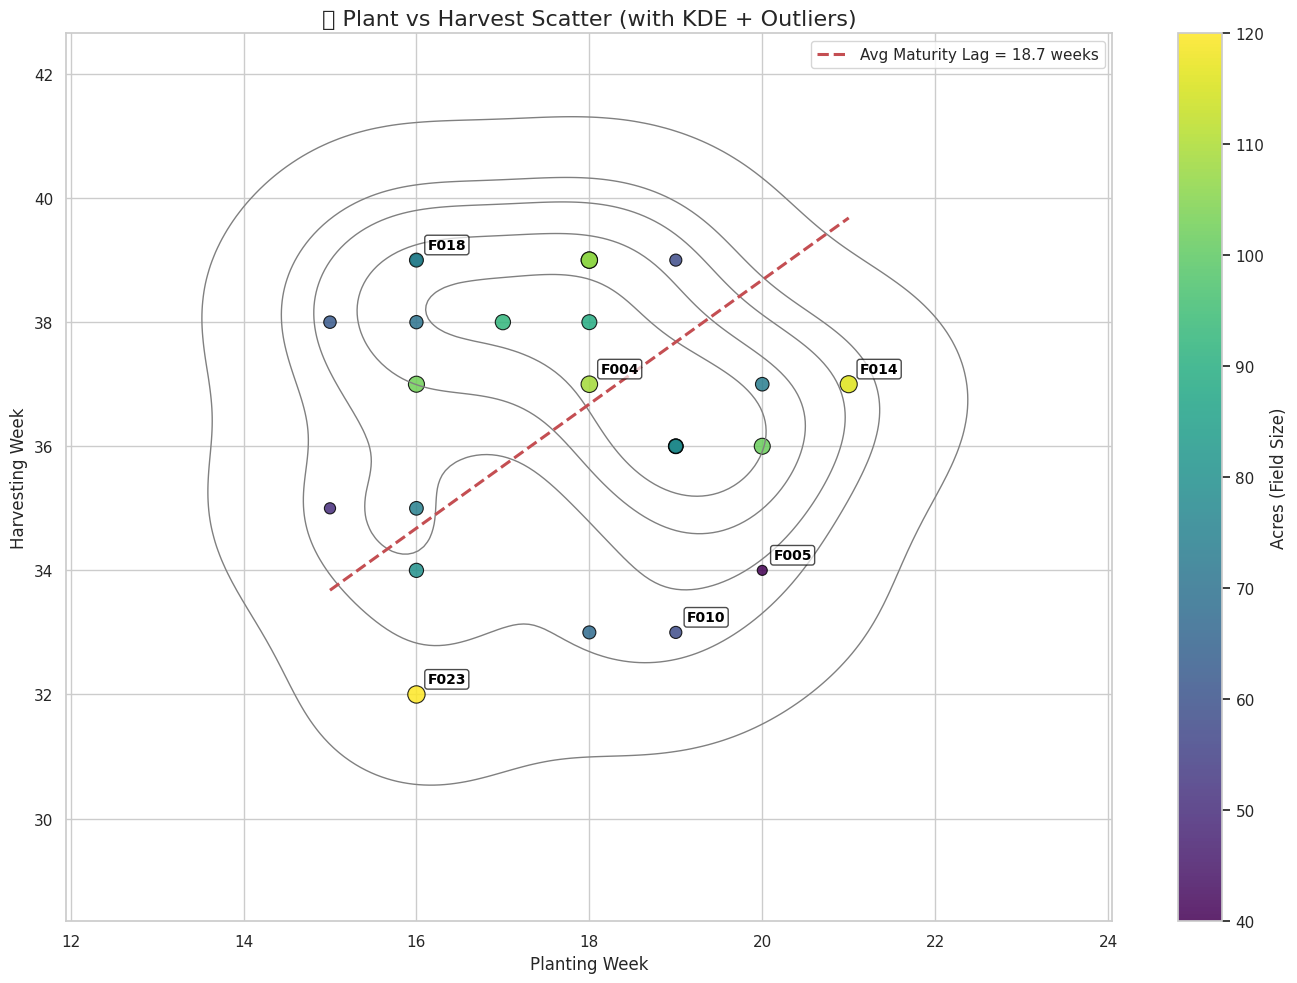

/tmp/ipykernel_8637/2908257182.py:105: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/mak/Documents/Optimization/Project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


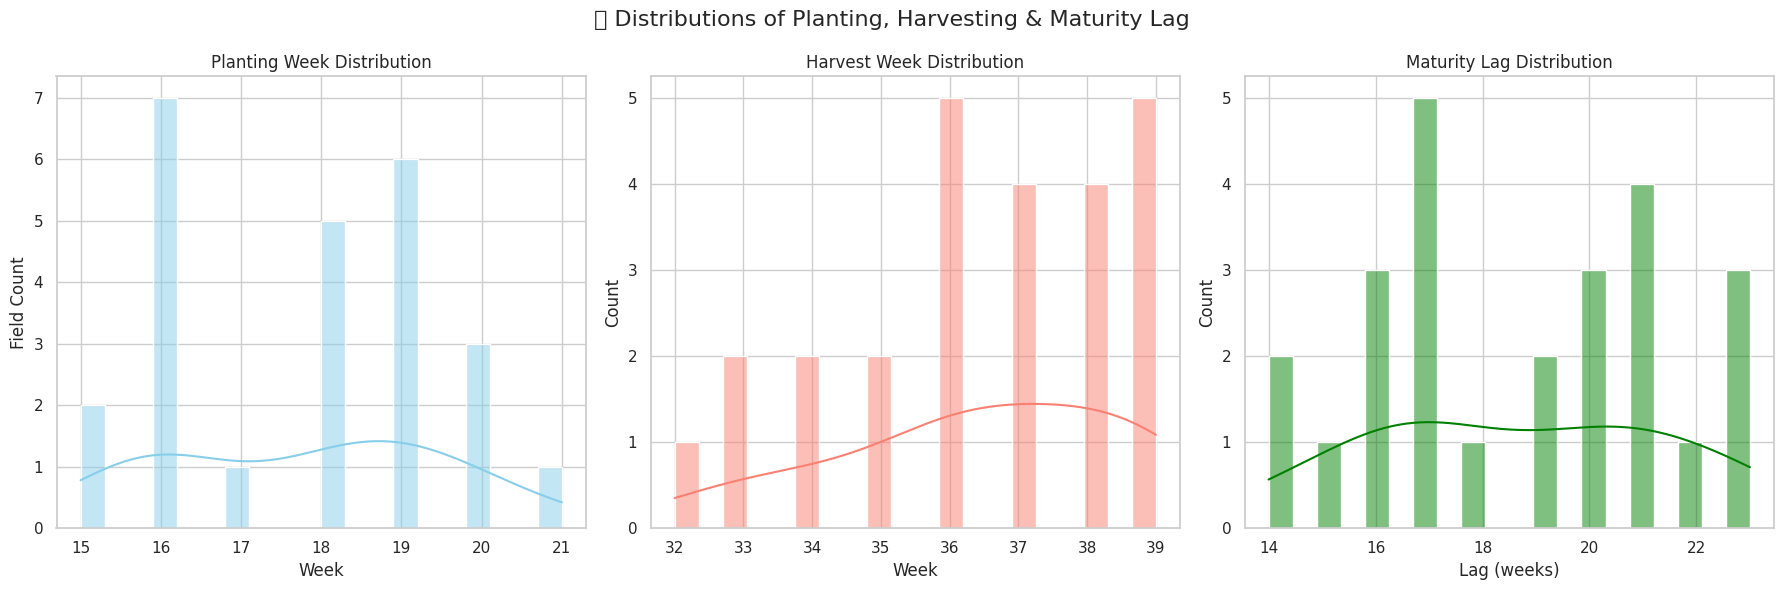

/tmp/ipykernel_8637/2908257182.py:130: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/mak/Documents/Optimization/Project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


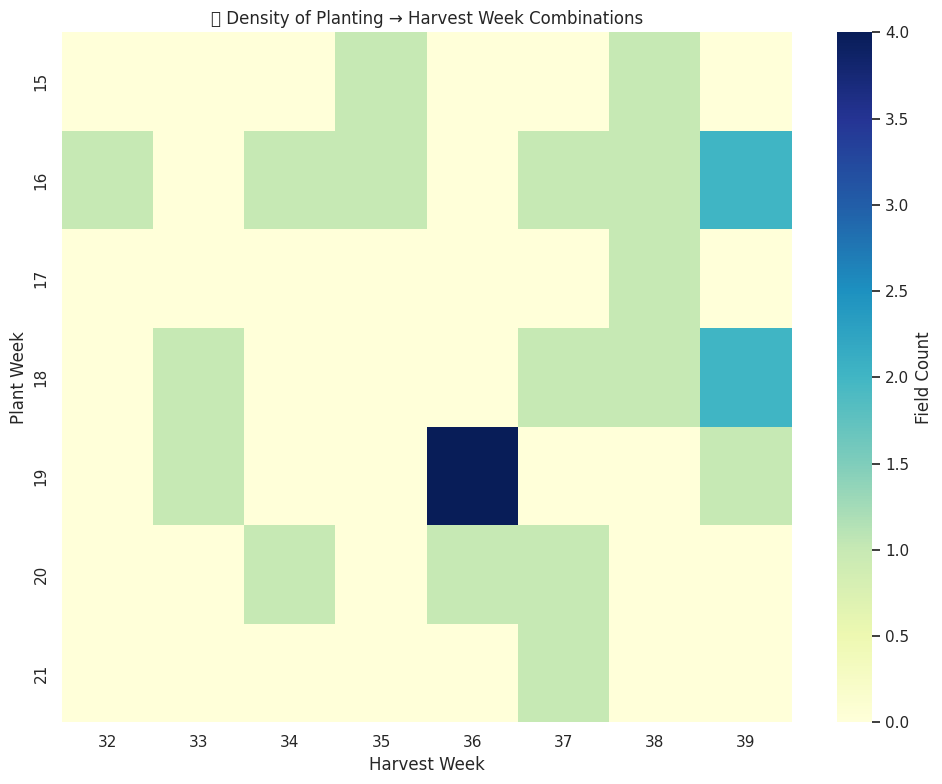

,field_id,plant_week,harvest_week,plant_week_cont,harvest_week_cont,early_penalty,late_penalty,status,makespan,acres,maturity_lag
0,F001,19,36,19.0,36.0,0.0,0.0,OK,39.0,87.227749,17
1,F002,19,36,19.0,36.0,0.0,0.0,OK,39.0,54.752514,17
2,F003,20,36,20.0,36.0,0.0,0.0,OK,39.0,101.833288,16
3,F004,18,37,18.0,37.0,0.0,0.0,OK,39.0,108.790255,19
4,F005,20,34,20.0,34.0,0.0,0.0,OK,39.0,40.000000,14
5,F006,15,35,15.0,35.0,0.0,0.0,OK,39.0,50.014717,20
6,F007,19,36,19.0,36.0,0.0,0.0,OK,39.0,82.034705,17
7,F008,16,38,16.0,38.0,0.0,0.0,OK,39.0,70.329222,22
8,F009,19,36,19.0,36.0,0.0,0.0,OK,39.0,78.020629,17
9,F010,19,33,19.0,33.0,0.0,0.0,OK,39.0,58.406055,14


In [20]:
plot_full_maturity_suite(sched, fields)


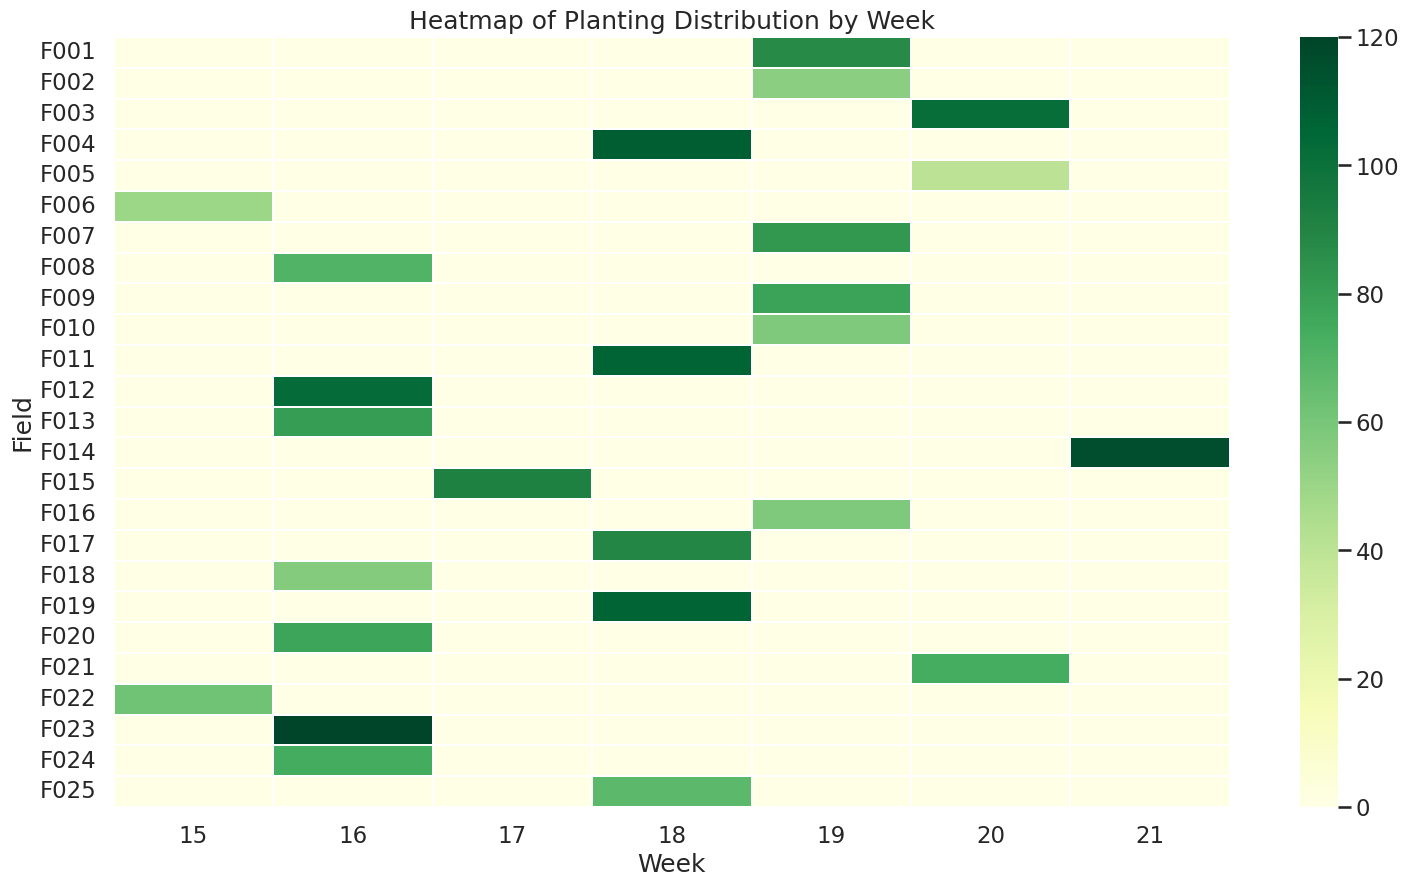

In [ ]:
def plot_planting_heatmap(sched):
    pivot = sched.pivot_table(
        index="field_id", 
        columns="plant_week", 
        values="acres", 
        fill_value=0
    )

    plt.figure(figsize=(18,10))
    sns.heatmap(pivot, cmap="YlGn", linewidths=0.2)
    plt.title("Heatmap of Planting Distribution by Week")
    plt.xlabel("Week")
    plt.ylabel("Field")
    plt.show()
plot_planting_heatmap(sched)

In [26]:
sched.loc[17:45]
sched.head(5)

,field_id,plant_week,harvest_week,plant_week_cont,harvest_week_cont,early_penalty,late_penalty,status,makespan
0,F001,19,36,19.0,36.0,0.0,0.0,OK,39.0
1,F002,19,36,19.0,36.0,0.0,0.0,OK,39.0
2,F003,20,36,20.0,36.0,0.0,0.0,OK,39.0
3,F004,18,37,18.0,37.0,0.0,0.0,OK,39.0
4,F005,20,34,20.0,34.0,0.0,0.0,OK,39.0


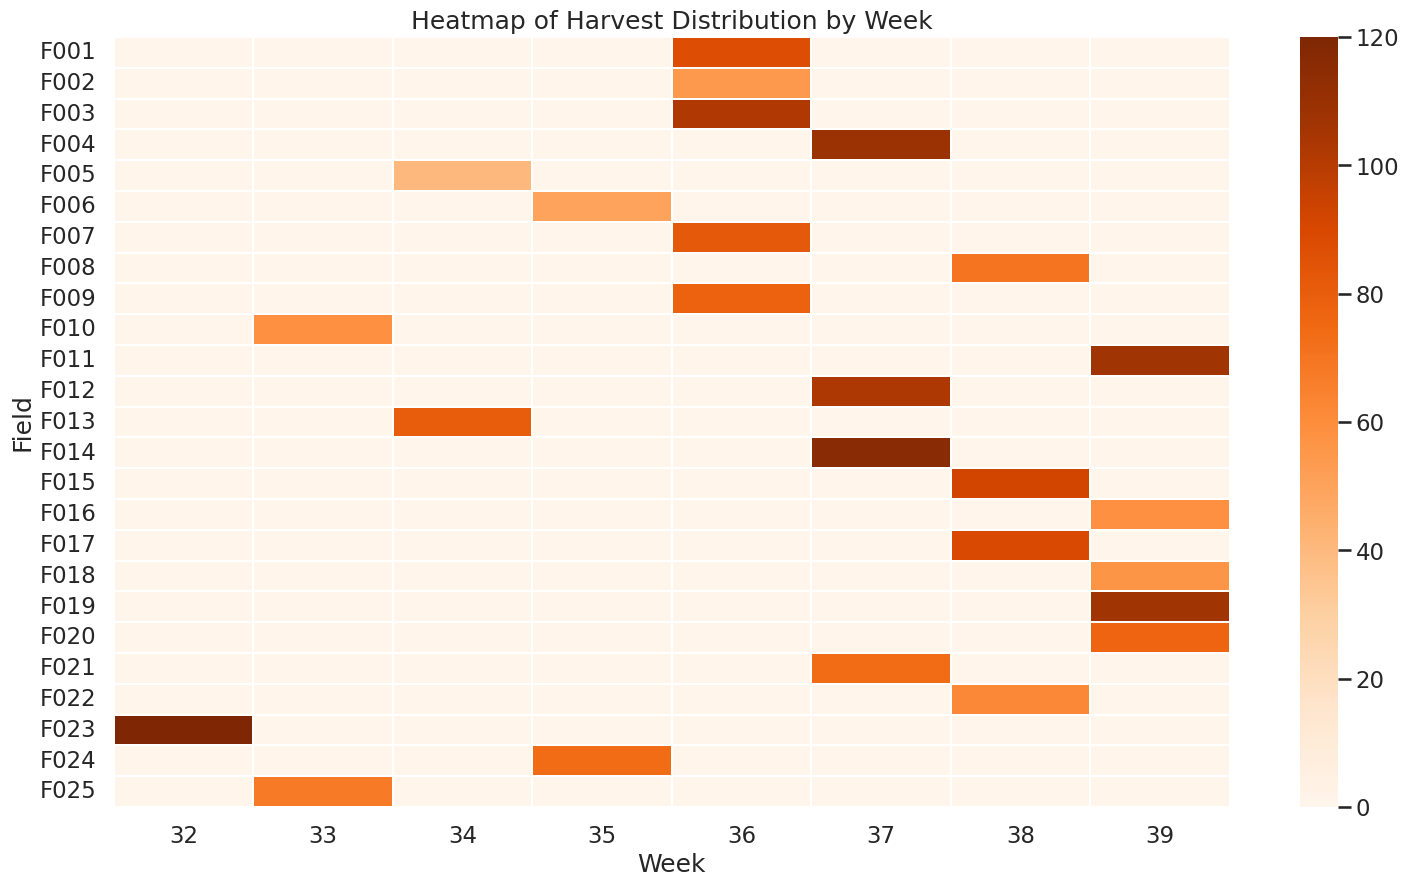

In [ ]:
def plot_harvest_heatmap(sched):
    pivot = sched.pivot_table(
        index="field_id", 
        columns="harvest_week", 
        values="acres", 
        fill_value=0
    )

    plt.figure(figsize=(18,10))
    sns.heatmap(pivot, cmap="Oranges", linewidths=0.2)
    plt.title("Heatmap of Harvest Distribution by Week")
    plt.xlabel("Week")
    plt.ylabel("Field")
    plt.show()
plot_harvest_heatmap(sched)

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_machine_capacity_curves(weekly_view, target_year=2017):
    """
    Visualize planting/harvesting demand vs machine capacity per week.
    Compatible with your weekly_view from plot_resource_dashboard().
    """

    sns.set_theme(style="whitegrid", context="talk")
    weeks = weekly_view["week"]

    fig, axes = plt.subplots(2, 1, figsize=(16, 12), sharex=True)
    plt.subplots_adjust(hspace=0.35)

    # ---------------------------------------------------------
    # 1) PLANTER DEMAND vs CAPACITY
    # ---------------------------------------------------------
    axes[0].plot(
        weeks, weekly_view["plant_acres"], 
        marker="o", linewidth=2.5, label="Planting Demand (acres)", color="#1f77b4"
    )
    axes[0].plot(
        weeks, weekly_view["plant_capacity_model"], 
        linestyle="--", linewidth=2.5, label="Planter Capacity (acres)", color="#ff7f0e"
    )
    axes[0].set_title(f"Planter – Demand vs Capacity ({target_year})", fontsize=18)
    axes[0].set_ylabel("Acres")
    axes[0].legend(loc="upper left")
    axes[0].grid(True, alpha=0.3)

    # ---------------------------------------------------------
    # 2) HARVESTER DEMAND vs CAPACITY
    # ---------------------------------------------------------
    axes[1].plot(
        weeks, weekly_view["harvest_acres"], 
        marker="o", linewidth=2.5, label="Harvest Demand (acres)", color="#2ca02c"
    )
    axes[1].plot(
        weeks, weekly_view["harvest_capacity_model"], 
        linestyle="--", linewidth=2.5, label="Harvester Capacity (acres)", color="#d62728"
    )
    axes[1].set_title(f"Harvester – Demand vs Capacity ({target_year})", fontsize=18)
    axes[1].set_ylabel("Acres")
    axes[1].set_xlabel("Week")
    axes[1].legend(loc="upper left")
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


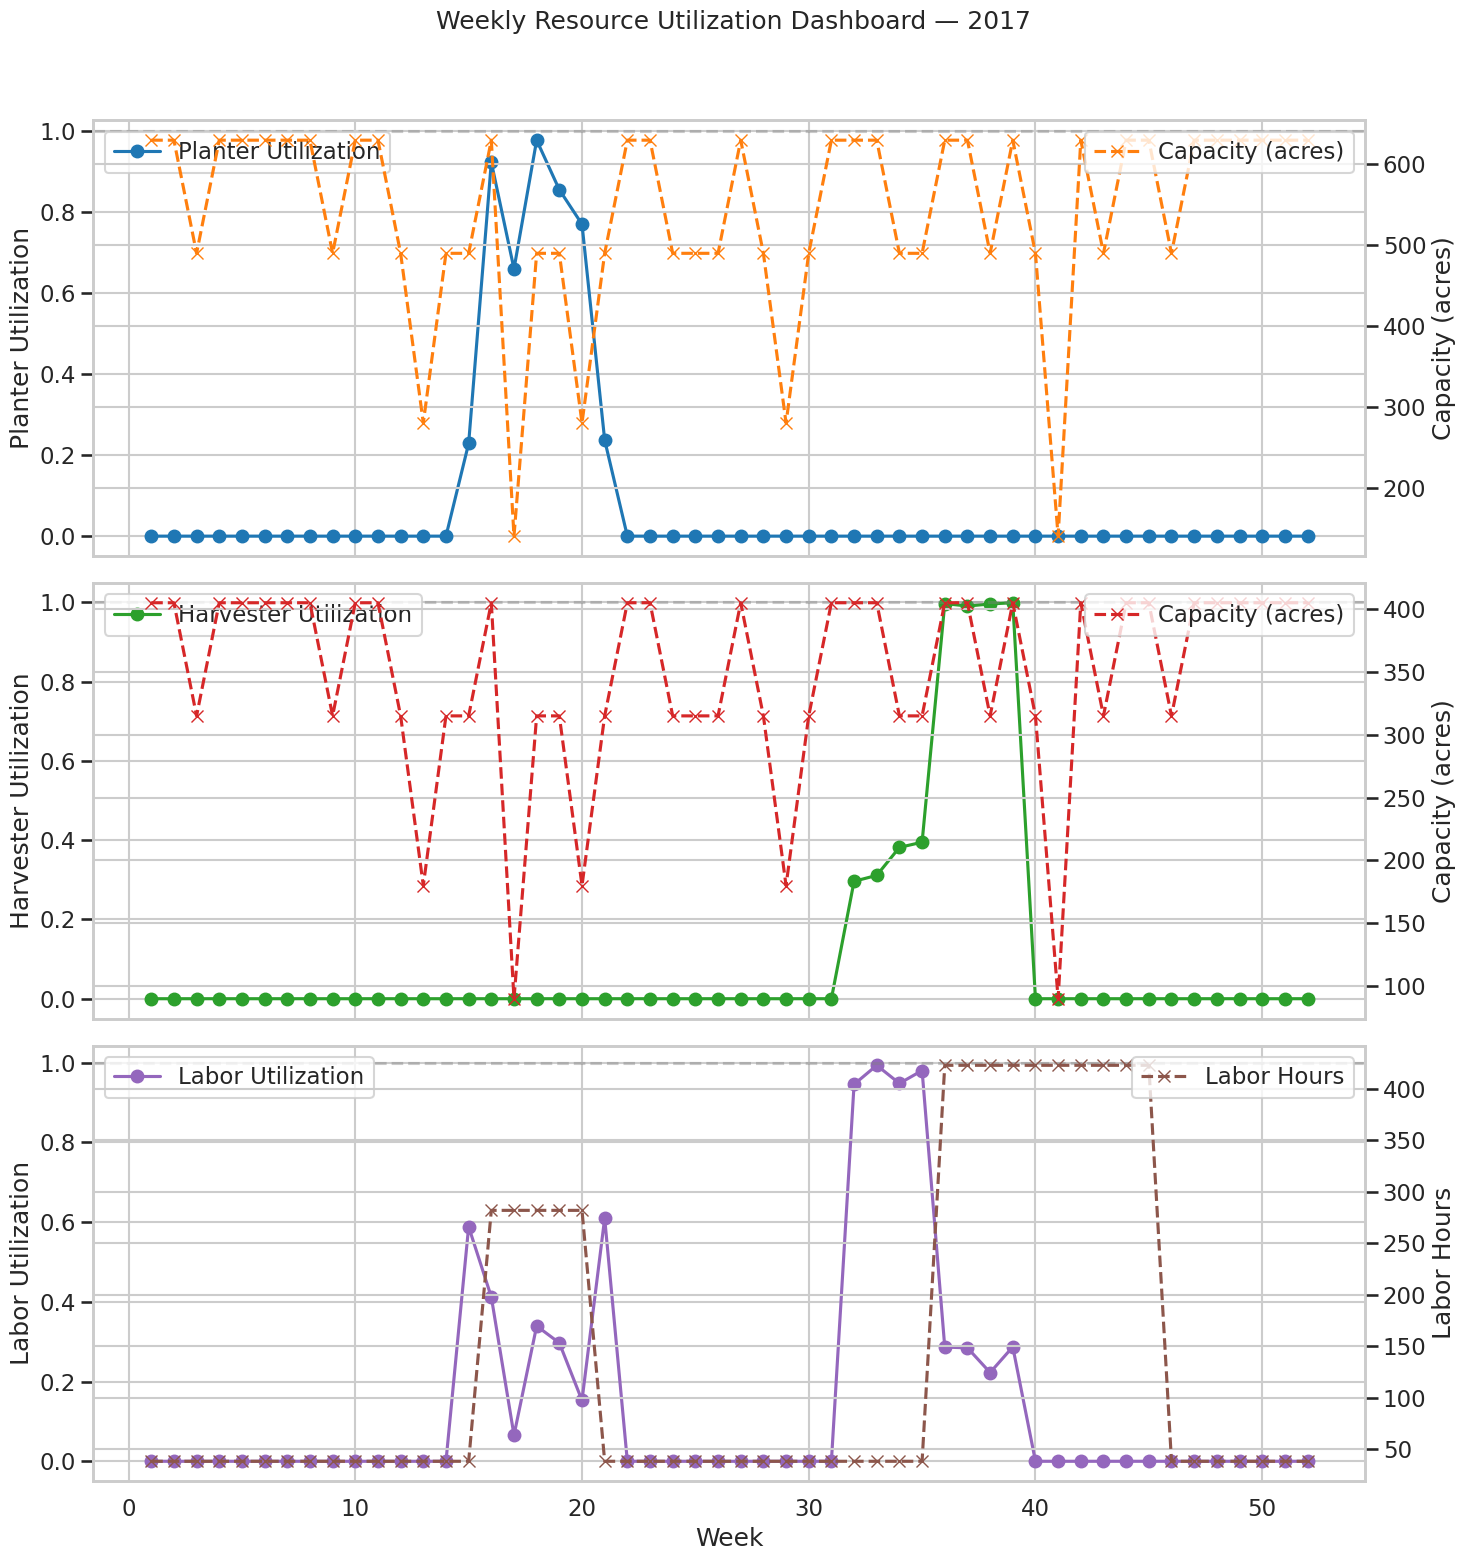

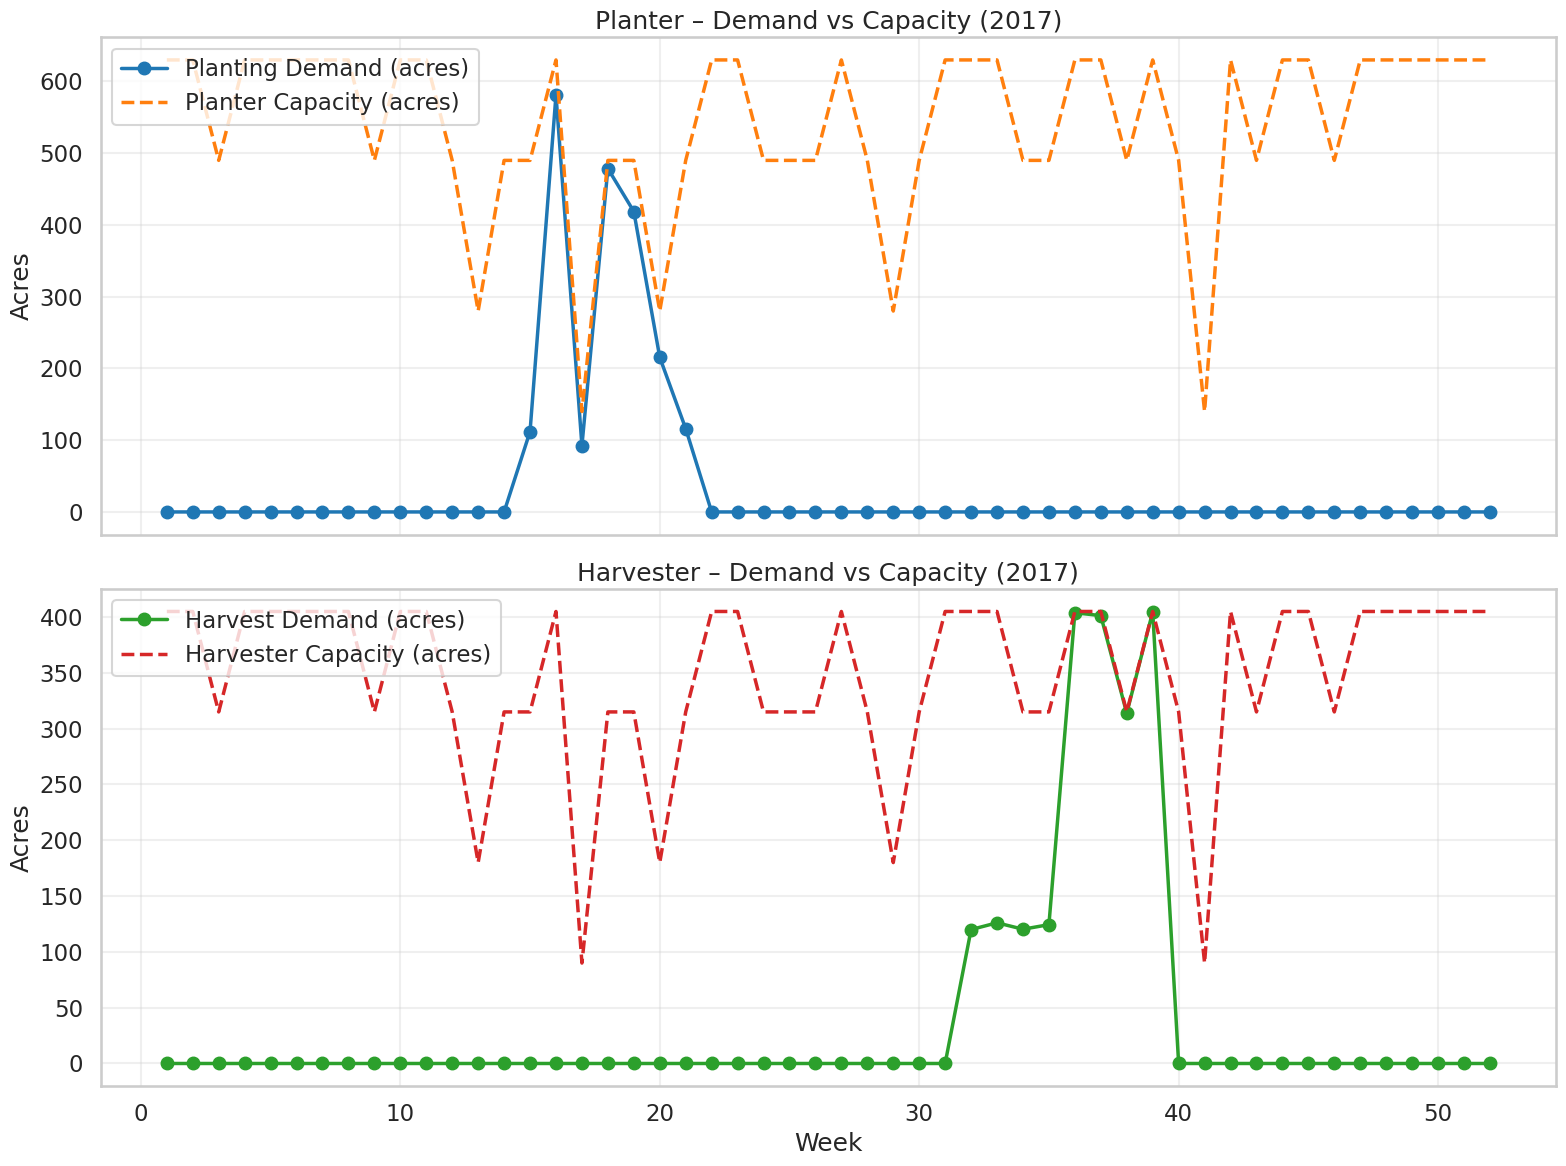

In [83]:
weekly_view = plot_resource_dashboard(sched, fields, wm, target_year=2017)
plot_machine_capacity_curves(weekly_view)


In [106]:

# plot_labor_demand_vs_available(weekly_view)
# sched

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_resource_dashboard(
    sched,
    fields,
    wm,
    target_year=2017,
    base_planter_capacity=700.0,
    base_harvester_capacity=450.0,
    labor_plant_per_acre=0.2,
    labor_harvest_per_acre=0.30,
    planter_machines=1,
    harvester_machines=1,
    save_path=None
):
    """
    Nicely styled, professional resource utilization dashboard for:
    - Planter utilization
    - Harvester utilization
    - Labor utilization
    
    sched: schedule_output (MILP result)
    fields: cleaned fields table (with acres)
    wm: weekly_master table (2017–2024)
    """

    # ------------------------------------------
    # 1. Prepare data
    # ------------------------------------------
    sched = sched.merge(fields[["field_id", "acres"]], on="field_id", how="left")

    wm_year = wm[wm["year"] == target_year].copy()
    wm_year["week"] = wm_year["week"].astype(int)

    wm_year["planter_travel_factor"] = wm_year.get("planter_travel_factor", 1.0)
    wm_year["harvest_weather_factor"] = wm_year.get("harvest_weather_factor", 1.0)

    # Aggregate to one row per week
    wm_weekly = (
        wm_year.groupby("week", as_index=False)
        .agg({
            "capacity_factor": "mean",
            "labor_hours": "sum",
            "planter_travel_factor": "mean",
            "harvest_weather_factor": "mean"
        })
    )

    # 🔥 DO NOT SCALE LABOR ANYMORE
    wm_weekly["labor_hours_available"] = wm_weekly["labor_hours"]

    # summarize planting / harvesting
    plant_by_week = sched.groupby("plant_week")["acres"].sum().rename("plant_acres")
    harvest_by_week = sched.groupby("harvest_week")["acres"].sum().rename("harvest_acres")

    weekly_view = (
        wm_weekly
        .merge(plant_by_week, left_on="week", right_index=True, how="left")
        .merge(harvest_by_week, left_on="week", right_index=True, how="left")
        .fillna(0.0)
    )

    # apply final capacities
    weekly_view["plant_capacity_model"] = (
        base_planter_capacity *
        weekly_view["capacity_factor"] *
        weekly_view["planter_travel_factor"] *
        planter_machines
    )

    weekly_view["harvest_capacity_model"] = (
        base_harvester_capacity *
        weekly_view["capacity_factor"] *
        weekly_view["harvest_weather_factor"] *
        harvester_machines
    )

    # utilizations
    weekly_view["plant_utilization"] = (
        weekly_view["plant_acres"] / weekly_view["plant_capacity_model"].replace(0, pd.NA)
    ).fillna(0)

    weekly_view["harvest_utilization"] = (
        weekly_view["harvest_acres"] / weekly_view["harvest_capacity_model"].replace(0, pd.NA)
    ).fillna(0)

    weekly_view["labor_demand"] = (
        weekly_view["plant_acres"] * labor_plant_per_acre +
        weekly_view["harvest_acres"] * labor_harvest_per_acre
    )

    weekly_view["labor_utilization"] = (
        weekly_view["labor_demand"] / weekly_view["labor_hours_available"].replace(0, pd.NA)
    ).fillna(0)

    # ------------------------------------------
    # 2. Plot styling
    # ------------------------------------------
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
    weeks = weekly_view["week"].values

    def add_dual_axis(ax, x, y1, y2, label1, label2, color1, color2):
        """Clean helper for dual-axis professional plot."""
        ax.plot(x, y1, marker="o", color=color1, label=label1, linewidth=2)
        ax.axhline(100, linestyle="--", color="gray", alpha=0.4)
        ax.set_ylabel(label1, color=color1, fontsize=12)
        ax.tick_params(axis="y", labelcolor=color1)
        ax.grid(alpha=0.3)

        ax2 = ax.twinx()
        ax2.plot(x, y2, marker="x", linestyle="--", color=color2, label=label2, linewidth=2)
        ax2.set_ylabel(label2, color=color2, fontsize=12)
        ax2.tick_params(axis="y", labelcolor=color2)

        # combine legends
        h1, l1 = ax.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax.legend(h1 + h2, l1 + l2, loc="upper left")

        return ax, ax2

    # ------------------------------------------
    # 3. Draw three panels
    # ------------------------------------------
    # Planter
    add_dual_axis(
        axes[0], weeks,
        weekly_view["plant_utilization"] * 100,
        weekly_view["plant_capacity_model"],
        "Planter Utilization (%)",
        "Planter Capacity (acres)",
        "#1f77b4", "#ff7f0e"
    )

    # Harvester
    add_dual_axis(
        axes[1], weeks,
        weekly_view["harvest_utilization"] * 100,
        weekly_view["harvest_capacity_model"],
        "Harvester Utilization (%)",
        "Harvester Capacity (acres)",
        "#2ca02c", "#d62728"
    )

    # Labor
    add_dual_axis(
        axes[2], weeks,
        weekly_view["labor_utilization"] * 100,
        weekly_view["labor_hours_available"],
        "Labor Utilization (%)",
        "Labor Hours Available",
        "#9467bd", "#8c564b"
    )

    # ------------------------------------------
    # 4. Final layout polish
    # ------------------------------------------
    axes[2].set_xlabel("Week", fontsize=12)
    fig.suptitle(f"Weekly Resource Utilization Dashboard — {target_year}", fontsize=16, weight="bold")
    fig.tight_layout(rect=[0, 0, 1, 0.96])

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()

    return weekly_view


/tmp/ipykernel_15767/1596520625.py:17: UserWarning: Glyph 127805 (\N{EAR OF MAIZE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/mak/Documents/Optimization/Project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127805 (\N{EAR OF MAIZE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


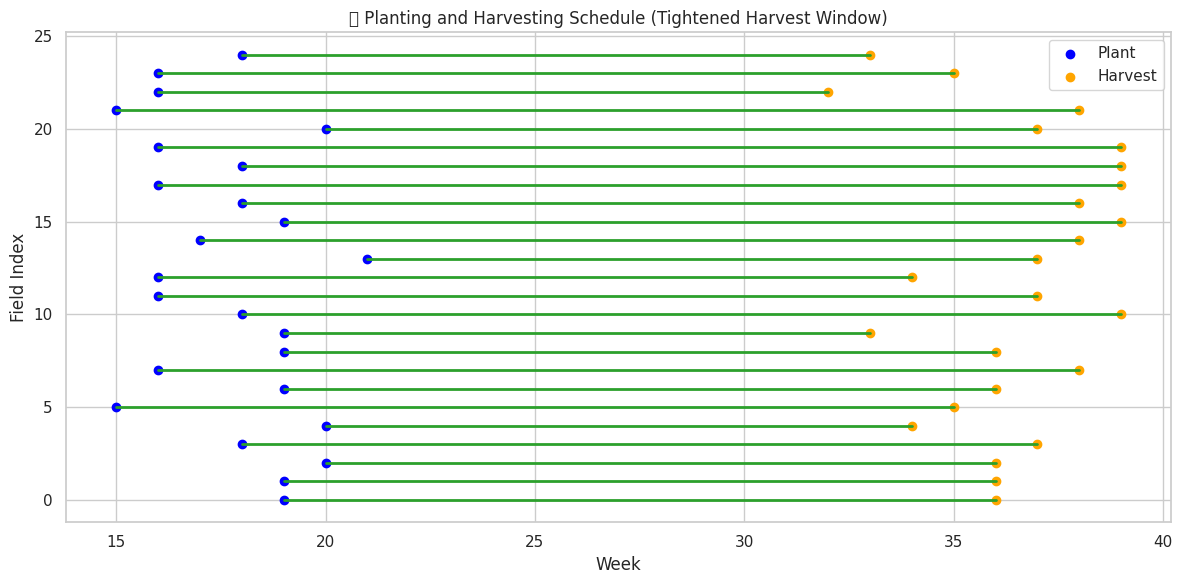

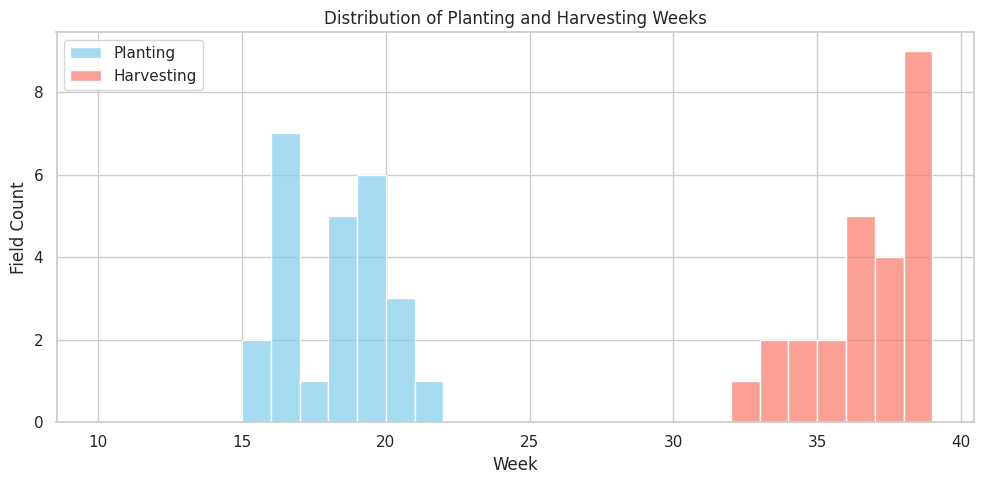

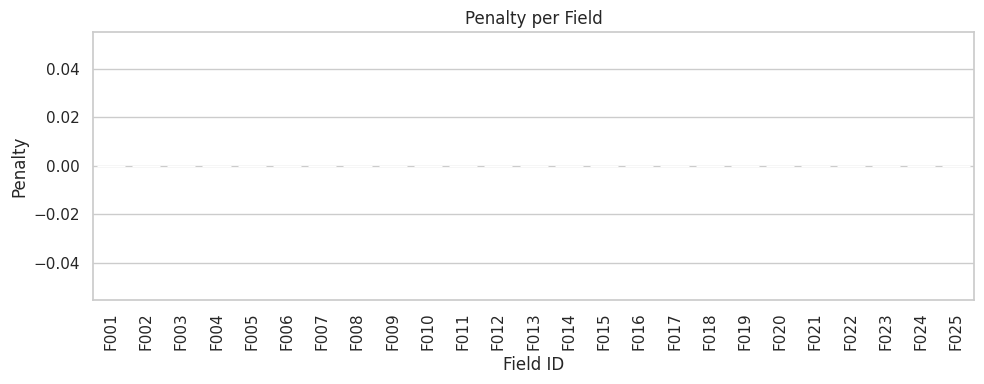

In [108]:
# Load the current output (tightened harvest window)
tightened_df = pd.read_csv("../../data/processed/schedule_outputv5.csv")
tightened_df["penalty"] = tightened_df["early_penalty"] + tightened_df["late_penalty"]


# Plot 1: Gantt-style plot of planting and harvesting weeks
plt.figure(figsize=(12, 6))
for i, row in tightened_df.iterrows():
    plt.plot([row["plant_week"], row["harvest_week"]], [i, i], color="tab:green", linewidth=2)
    plt.scatter(row["plant_week"], i, color="blue", label="Plant" if i == 0 else "")
    plt.scatter(row["harvest_week"], i, color="orange", label="Harvest" if i == 0 else "")
plt.xlabel("Week")
plt.ylabel("Field Index")
plt.title("🌽 Planting and Harvesting Schedule (Tightened Harvest Window)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Histogram of Planting and Harvesting Weeks
plt.figure(figsize=(10, 5))
sns.histplot(tightened_df["plant_week"], bins=range(10, 40), kde=False, label="Planting", color="skyblue")
sns.histplot(tightened_df["harvest_week"], bins=range(10, 40), kde=False, label="Harvesting", color="salmon")
plt.xlabel("Week")
plt.ylabel("Field Count")
plt.title("Distribution of Planting and Harvesting Weeks")
plt.legend()
plt.tight_layout()
plt.show()

# Plot 3: Penalty Distribution
plt.figure(figsize=(10, 4))
sns.barplot(x="field_id", y="penalty", data=tightened_df)
plt.xticks(rotation=90)
plt.title("Penalty per Field")
plt.xlabel("Field ID")
plt.ylabel("Penalty")
plt.tight_layout()
plt.show()


In [ ]:
print(df[["field_id", "plant_week", "harvest_week", "penalty", "objective_makespan"]])

In [86]:
# Load fields dataset
fields = pd.read_csv("../../data/processed/illinois_corn_fields_clean.csv")

# Only keep needed columns
fields = fields[["field_id", "acres"]]

# Merge into sched
sched = sched.merge(fields, on="field_id", how="left")

# Optional sanity check
print(sched.head())


  field_id  plant_week  harvest_week  plant_week_cont  harvest_week_cont  \
0     F001          19            36             19.0               36.0   
1     F002          19            36             19.0               36.0   
2     F003          20            36             20.0               36.0   
3     F004          18            37             18.0               37.0   
4     F005          20            34             20.0               34.0   

   early_penalty  late_penalty status  makespan       acres  
0            0.0           0.0     OK      39.0   87.227749  
1            0.0           0.0     OK      39.0   54.752514  
2            0.0           0.0     OK      39.0  101.833288  
3            0.0           0.0     OK      39.0  108.790255  
4            0.0           0.0     OK      39.0   40.000000  


In [87]:
def plot_cumulative_progress(sched):
    # Ensure acres exists
    if "acres" not in sched.columns:
        raise ValueError("sched must contain an 'acres' column. Merge fields first.")

    # Sort
    sched_p = sched.sort_values("plant_week")
    sched_h = sched.sort_values("harvest_week")

    # Compute cumulative
    cum_plant = sched_p["acres"].cumsum()
    cum_harvest = sched_h["acres"].cumsum()

    plt.figure(figsize=(14, 6))

    plt.step(
        sched_p["plant_week"],
        cum_plant,
        where="post",
        label="Cumulative Planting",
        linewidth=3,
        color="green"
    )
    plt.step(
        sched_h["harvest_week"],
        cum_harvest,
        where="post",
        label="Cumulative Harvesting",
        linewidth=3,
        color="orange"
    )

    plt.title("Cumulative Planting & Harvesting Progress")
    plt.xlabel("Week")
    plt.ylabel("Acres")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


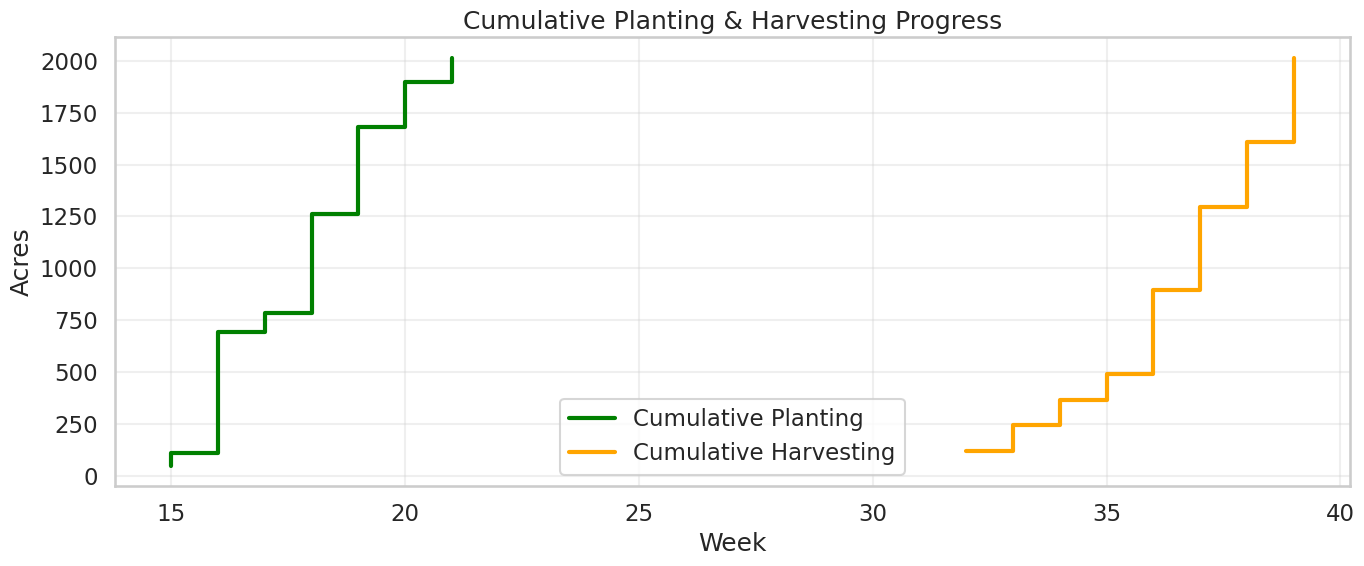

In [88]:
plot_cumulative_progress(sched)


In [90]:
def plot_milp_gantt(sched):
    sched = sched.sort_values("plant_week").reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(18, 14))

    bar_h = 0.6  # thinner for 30+ fields

    for i, row in sched.iterrows():
        fid = row["field_id"]
        pw = row["plant_week"]
        hw = row["harvest_week"]
        acres = row["acres"]

        ax.barh(
            y=i,
            width=1,
            left=pw,
            height=bar_h,
            color="#4daf4a",
            alpha=0.9,
            label="Plant" if i == 0 else "",
        )

        ax.barh(
            y=i,
            width=1,
            left=hw,
            height=bar_h,
            color="#ff7f00",
            alpha=0.9,
            label="Harvest" if i == 0 else "",
        )

        ax.text(
            hw + 0.1, 
            i, 
            f"{fid} ({acres:.0f} ac)", 
            va="center", 
            fontsize=7
        )

    ax.set_yticks(range(len(sched)))
    ax.set_yticklabels(sched["field_id"], fontsize=7)

    ax.set_xlabel("Week")
    ax.set_title("MILP Optimized Schedule — Gantt Chart (30 Fields)", fontsize=16)
    plt.grid(axis="x", linestyle="--", alpha=0.4)
    ax.legend()
    plt.tight_layout()
    plt.show()


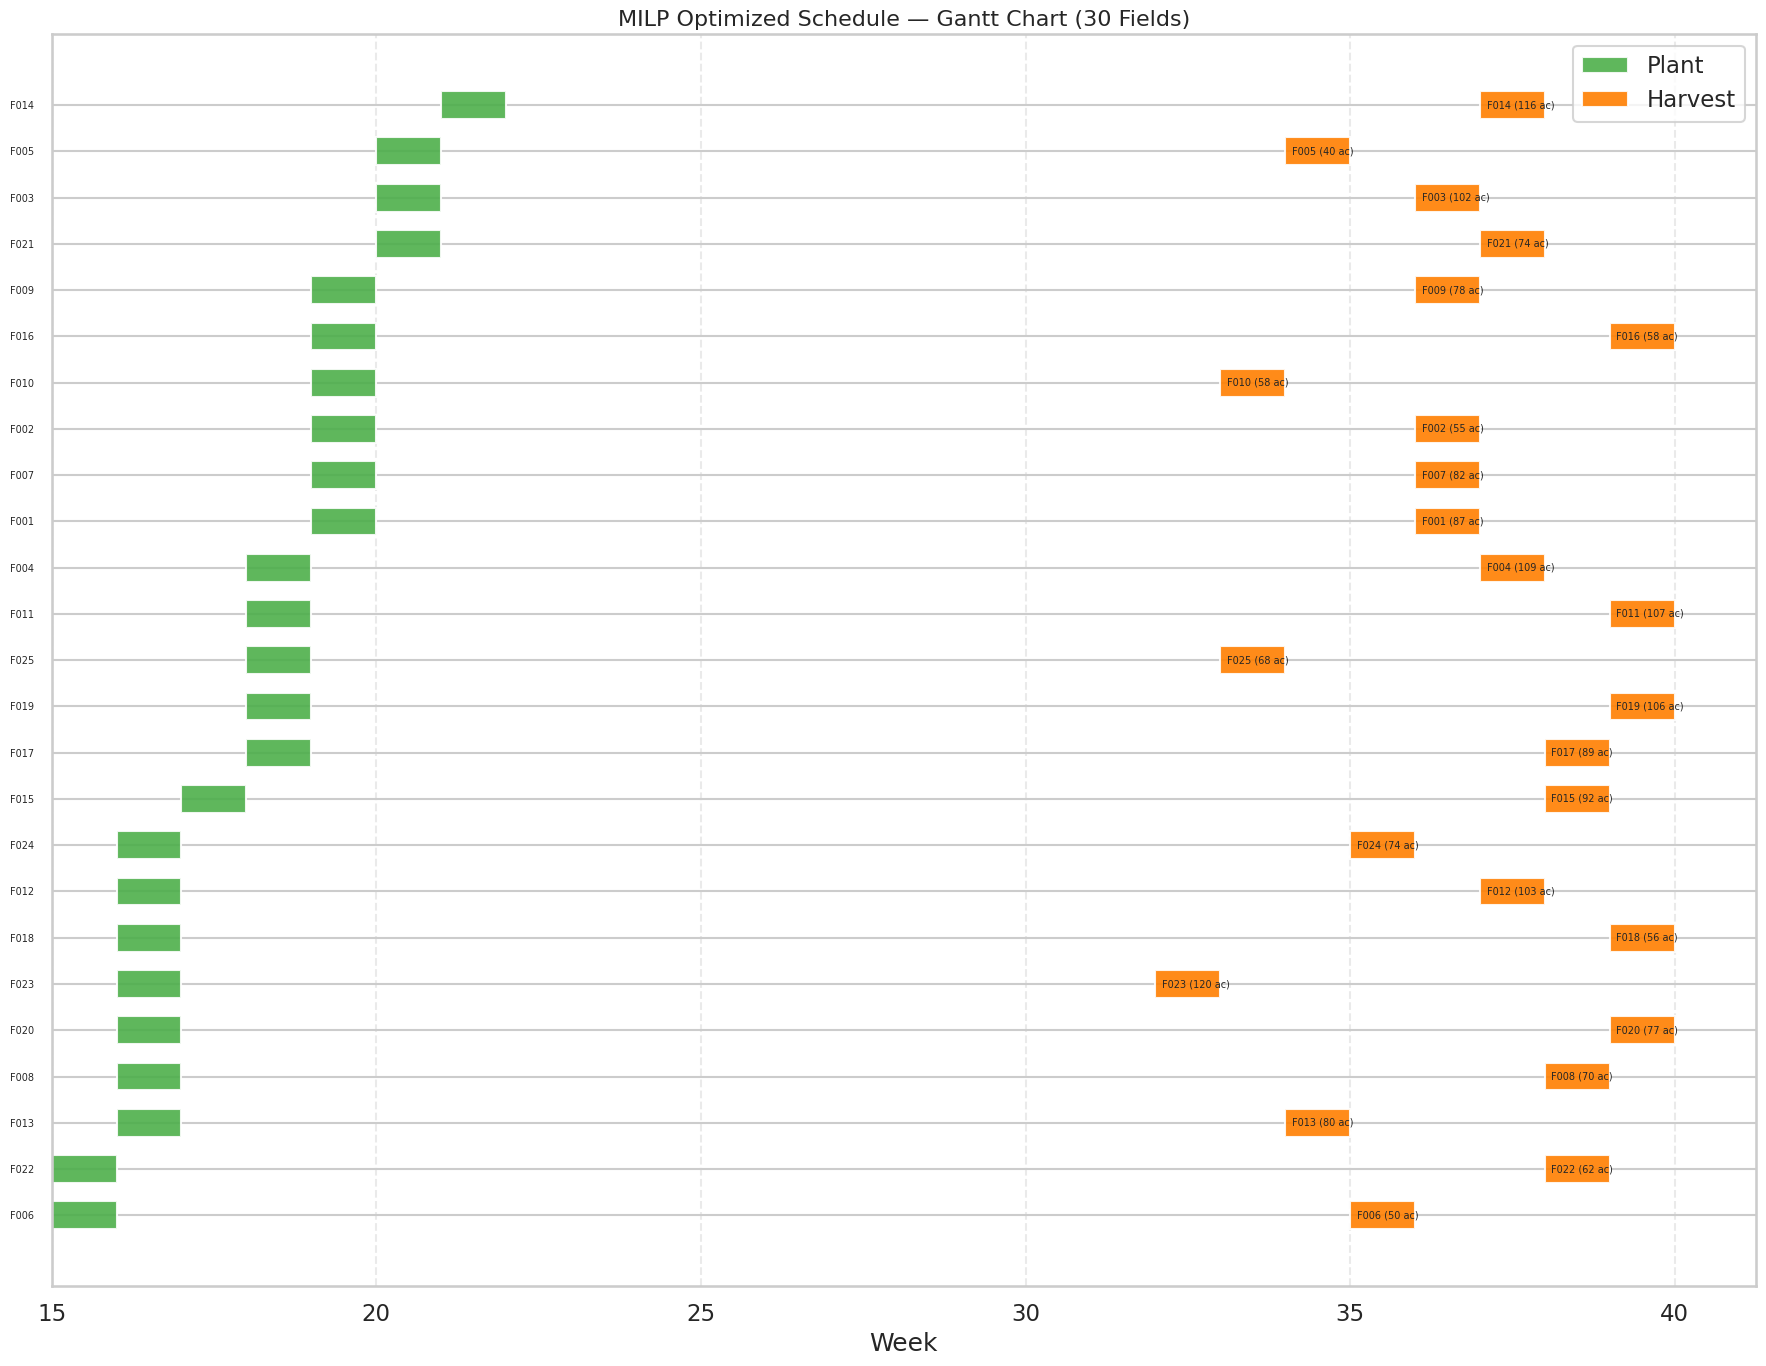

In [91]:
plot_milp_gantt(sched)


In [102]:
# sched